In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load and Preprocess the Dataset 

In [13]:
DATASET_PATH = "flowers"  

# parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation & Loading
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


In [14]:
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


# Load Pre-Trained MobileNetV2 Model

In [15]:
# Load Pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze initial layers

# Custom Classification Head

In [16]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])


# Compile Mode

In [17]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#  Train Model with Early Stopping

In [18]:
#
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping])


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.5735 - loss: 1.1262 - val_accuracy: 0.8302 - val_loss: 0.4649
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7923 - loss: 0.5588 - val_accuracy: 0.8407 - val_loss: 0.4265
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8205 - loss: 0.4983 - val_accuracy: 0.8535 - val_loss: 0.4062
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8319 - loss: 0.4700 - val_accuracy: 0.8698 - val_loss: 0.3843
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8377 - loss: 0.4359 - val_accuracy: 0.8616 - val_loss: 0.3752
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8538 - loss: 0.4128 - val_accuracy: 0.8640 - val_loss: 0.3806
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8574 - loss: 0.3862 - val_accuracy: 0.8488 - val_loss: 0.3972
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8655 - loss: 0.3624 - val_accu

# Fine-tuning Unfreeze some deeper layers

In [19]:
base_model.trainable = True
for layer in base_model.layers[:100]: 
    layer.trainable = False


# Compile again with lower learning rate

In [20]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Again 

In [21]:
model.fit(train_generator, validation_data=val_generator, epochs=4, callbacks=[early_stopping])


Epoch 1/4
109/109 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.8134 - loss: 0.5154 - val_accuracy: 0.7453 - val_loss: 1.0361
Epoch 2/4
109/109 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.8892 - loss: 0.3031 - val_accuracy: 0.8081 - val_loss: 0.7221
Epoch 3/4
109/109 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.9167 - loss: 0.2483 - val_accuracy: 0.8430 - val_loss: 0.5535
Epoch 4/4
109/109 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.9290 - loss: 0.2108 - val_accuracy: 0.8430 - val_loss: 0.6968


# Evaluate Performance 

In [22]:
val_generator.reset()
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
              precision    recall  f1-score   support

       daisy       0.11      0.11      0.11       152
   dandelion       0.25      0.43      0.32       210
        rose       0.16      0.09      0.11       156
   sunflower       0.10      0.03      0.05       146
       tulip       0.23      0.24      0.24       196

    accuracy                           0.20       860
   macro avg       0.17      0.18      0.17       860
weighted avg       0.18      0.20      0.18       860



# Confusion Matrix

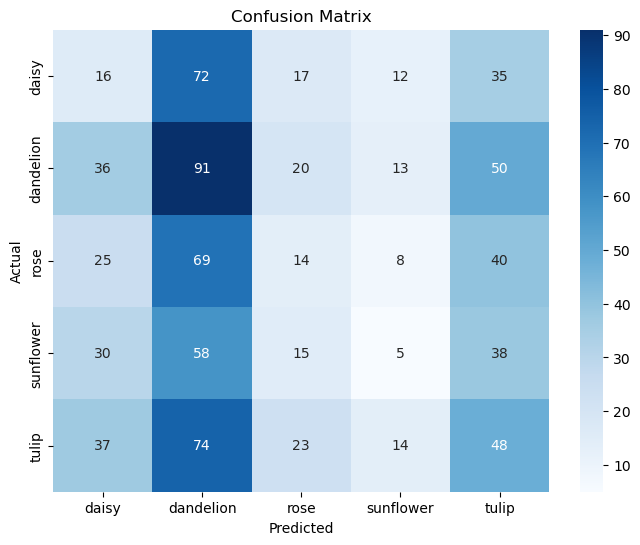

In [23]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# Saving the Model 

In [24]:
model.save("flower_classification_mobilenetv2.h5")
